# Mortality Data Analysis

### Preprocessing

In [42]:
def education_calc(row):
    flag = row['education_reporting_flag']
    rev_89 = row['education_1989_revision']
    rev_03 = row['education_2003_revision']
    
    # 1989 recode
    if flag == 0:
        # If not stated
        if rev_89 == 99:
            return 0
        # If primary school or less
        elif rev_89 >= 0 and rev_89 <= 8:
            return 1
        # If some amount of secondary school
        elif rev_89 >= 9 and rev_89 <= 12:
            return 2
        # Complete or currently working on associate's or bachelor's degree
        elif rev_89 >= 13 and rev_89 <= 16:
            return 3
        # >4 years of school
        else:
            return 4
    # 2003 recode
    elif flag == 1:
        # "unknown"
        if rev_03 == 9:
            return 0
        # primary school
        elif rev_03 == 1:
            return 1
        # Some amount of secondary school
        elif rev_03 == 2 or rev_03 == 3:
            return 2
        # College up to bachelors
        elif rev_03 == 4 or rev_03 == 5 or rev_03 == 6:
            return 3
        # >4 years
        else:
            return 4
    # Nothing reported
    else:
        return 0

In [2]:
#File loading method stack overflow link: https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
#All dataframe methods learned from pandas documentation
#np.where learned from numpy documentation

import numpy as np
import pandas as pd
import glob
import os
import pickle
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score
from sklearn import preprocessing
import matplotlib.pyplot as plt


filename = 'MortalityCondensed.csv'
pd.set_option('display.max_columns',500)
pd.options.mode.chained_assignment = None 

def process_files(local_path):
    #Load all .csv files in the mortality directory
    all_files = glob.glob(local_path + "/*.csv")
    dataframe = pd.DataFrame()
    file_list = []

    for file in all_files:
        df = pd.read_csv(file, index_col = None, header = 0, low_memory = False)

        dfInterest = df[['sex','race','detail_age','month_of_death', 'manner_of_death', 'education_reporting_flag','education_2003_revision','education_1989_revision','hispanic_origin']] #Isolate columns we need
        dfInterest['binary_male'] = np.where(dfInterest['sex']=='M', 1, 0)
        dfInterest['manner_of_death_cleaned'] = np.where(np.isnan(dfInterest['manner_of_death']), 0, dfInterest['manner_of_death'])
        #dfInterest['binary_suicide'] = np.where(dfInterest['manner_of_death']==2, 1, 0) #create the binary suicide column

        #Recode education to get rid of NaNs. Code 18 represents where we have no data.
        dfInterest['education'] = dfInterest.apply(education_calc, axis=1)
        print(dfInterest['education'].head())

        #Recode race to give us more meaningful categories 0 hispanic, 1 white, 2 black, 3 asian
        dfInterest['binary_white'] = np.where(dfInterest['race'] == 1, 1, 0)
        dfInterest['binary_black'] = np.where(dfInterest['race'] == 2, 1, 0)
        dfInterest['binary_asian'] = np.where(dfInterest['race'] > 2, 1, 0)
        dfInterest['binary_hispanic'] = np.where(dfInterest['hispanic_origin'] > 199, 1, 0)        
        file_list.append(dfInterest) #add the new dataframe to the list
    
    dataframe = pd.concat(file_list) #concat the whole list to the final dataframe
    finaldf = dataframe.drop(columns=['race', 'sex', 'education_reporting_flag','education_2003_revision','education_1989_revision'])

    # Reordering
    finaldf = finaldf[['binary_male', 'binary_white', 'binary_black', 'binary_asian', 'binary_hispanic',
                      'detail_age', 'month_of_death', 'education','manner_of_death_cleaned']]
    finaldf.to_csv(filename)
    finaldf.head()
    print(finaldf.isnull().sum())#showing number of null values, shoulw be 0 after recode


In [20]:
# Check if base_file exists
# If not, create it
if not os.path.isfile(filename):
    process_files("mortality")
df = pd.read_csv(filename, header=0, encoding='ISO-8859-1')
#new_df = df.sample(int(len(df)/4))
#print(new_df.head())
# Split into training and test
# https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
df = df[df.manner_of_death_cleaned != 0]
print(df['manner_of_death_cleaned'].value_counts())

msk = np.random.rand(len(df)) < 0.9
train = df[msk]
test = df[~msk]

Y_train = np.where(train.iloc[:,len(train.columns)-1] == 3, 1, 0)
#Y_train = train.iloc[:,len(train.columns)-1]
X_train = train.iloc[:,1:(len(train.columns)-1)]
Y_test = np.where(test.iloc[:,len(test.columns)-1] == 3, 1, 0)
#Y_test = test.iloc[:,len(test.columns)-1]
X_test = test.iloc[:,1:(len(test.columns)-1)]

7.0    19914162
1.0     1350268
2.0      423361
3.0      200528
5.0      119756
4.0       55808
Name: manner_of_death_cleaned, dtype: int64


## Predicting Suicide vs Non-Suicide

### Logistic Regression

/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


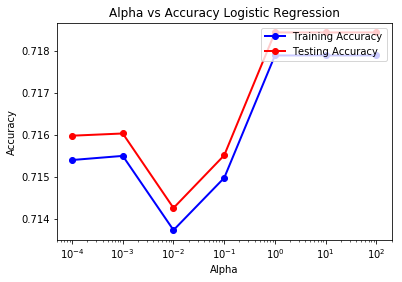

[0.7153981414725229, 0.7154964142458857, 0.71372870643879, 0.7149731943730272, 0.7178883194544329, 0.7178883194544329, 0.7178883194544329]
[0.7159772576451837, 0.7160300398302489, 0.7142552952486559, 0.7155107894455479, 0.7184363661134763, 0.7184363661134763, 0.7184363661134763]
CPU times: user 18min 25s, sys: 10.4 s, total: 18min 36s
Wall time: 18min 34s


In [45]:
%%time
alpha_arr = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0]
#alpha_arr = [0.01]
train_acc = []
test_acc = []
for a in alpha_arr:    
    classifier = SGDClassifier(loss='log', max_iter=200, tol=1.0e-9, random_state=123, alpha=a)
    classifier.fit(X_train, Y_train)
    # Add to accuracy lists
    train_acc.append(accuracy_score(Y_train, classifier.predict(X_train)))
    test_acc.append(accuracy_score(Y_test, classifier.predict(X_test)))

plt.figure(1)
plt.plot(alpha_arr, train_acc, color='blue', lw=2, marker='o', label="Training Accuracy")
plt.plot(alpha_arr, test_acc, color='red', lw=2, marker='o', label="Testing Accuracy")

ax = plt.gca()
ax.set_xscale('log')

plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Alpha vs Accuracy Logistic Regression")
plt.legend(loc='upper right')
plt.show()

print(train_acc)
print(test_acc)

In [17]:
### ONLY USEFUL IF WE USE GRIDSEARCH CV, MIGHT BE TOO SLOW
# Save output dict just in case
# https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-filew
with open(log_reg_fn, 'wb') as f:
    pickle.dump(gs_classifier.cv_results_, f)

# Load data
log_reg_res = {}
with open(log_reg_fn, 'rb') as f:
    log_reg_res = pickle.load(f)

NameError: name 'gs_classifier' is not defined

### Decision Tree

[0.         0.         0.37738544 0.         0.         0.62261456
 0.         0.        ]
[0.11214045 0.002779   0.2599819  0.         0.04746683 0.44748452
 0.         0.1301473 ]
[1.13884768e-01 9.00220700e-04 2.30937873e-01 1.96311868e-03
 4.24012481e-02 4.74321469e-01 4.93577252e-06 1.35586367e-01]
[1.11679184e-01 2.63963820e-03 2.24802238e-01 1.62920320e-04
 4.13109623e-02 4.73812050e-01 3.98295231e-04 1.45194712e-01]
[0.11075673 0.00075043 0.22255309 0.00210475 0.04163418 0.47367776
 0.00349285 0.14503022]
[1.09815986e-01 2.72751692e-03 2.20341179e-01 3.84201291e-04
 4.20596824e-02 4.72088803e-01 8.02622381e-03 1.44556408e-01]
[0.10848012 0.00103637 0.21734283 0.00234994 0.04250893 0.46962813
 0.01487853 0.14377514]
[0.10711167 0.00310923 0.2143926  0.00071318 0.04252411 0.46771064
 0.0214145  0.14302406]


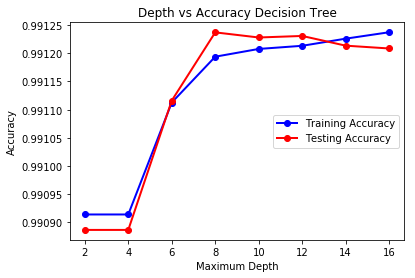

[0.9909142207784523, 0.9909142207784523, 0.9911126901820092, 0.991193971485572, 0.9912077198101522, 0.9912133097882784, 0.9912259501892661, 0.9912373315861714]
[0.9908868385685377, 0.9908868385685377, 0.9911161175902322, 0.9912371007894267, 0.9912280383775021, 0.9912307571010794, 0.9912135385184225, 0.9912085541918639]
CPU times: user 14min 31s, sys: 19.8 s, total: 14min 51s
Wall time: 14min 55s


In [21]:
%%time
depth_arr = [2,4,6,8,10,12,14,16]
#depth_arr = [10]
train_acc = []
test_acc = []

for d in depth_arr:    
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(X_train, Y_train)
    print(clf.feature_importances_)
    # Add to accuracy lists
    train_acc.append(accuracy_score(Y_train, clf.predict(X_train)))
    test_acc.append(accuracy_score(Y_test, clf.predict(X_test)))

plt.figure(1)
plt.plot(depth_arr, train_acc, color='blue', lw=2, marker='o', label="Training Accuracy")
plt.plot(depth_arr, test_acc, color='red', lw=2, marker='o', label="Testing Accuracy")

plt.xlabel("Maximum Depth")
plt.ylabel("Accuracy")
plt.title("Depth vs Accuracy Decision Tree")
plt.legend(loc='center right')
plt.show()

print(train_acc)
print(test_acc)

### ROC (Binary)

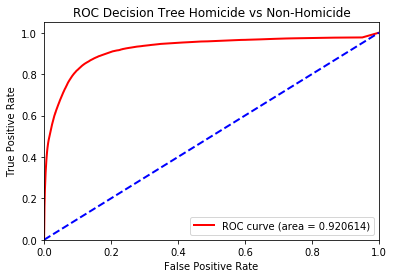

In [22]:
# ROC stuff
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(Y_test, clf.predict_proba(X_test)[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(2)
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Decision Tree Homicide vs Non-Homicide')
plt.legend(loc="lower right")
plt.show()

### ROC (Multiclass)

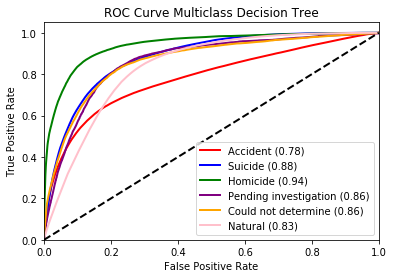

In [19]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# Example from
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

# Must use 1 vs rest as ROC doesn't do "actual" multiclass
classifier = OneVsRestClassifier(DecisionTreeClassifier(max_depth=10), n_jobs=6)
# Must also binarize y_test for onevsrest
binary_y_test = label_binarize(Y_test, classes=[1, 2, 3, 4, 5, 7])

classifier.fit(X_train, Y_train)
y_score = classifier.predict_proba(X_test)
n_classes = 6

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
# For all classes, calculate and store true, false positive rate, area under curve
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binary_y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink']
labels = ['Accident', 'Suicide', 'Homicide', 'Pending investigation', 'Could not determine', 'Natural']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} ({1:0.2f})'
             ''.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Multiclass Decision Tree')
plt.legend(loc="lower right")
plt.show()

### Linear SVM

In [ ]:
svm_fn = 'svm_gridsearch_output.pkl'

# Base svm classifier
base_classifier = SGDClassifier(max_iter=1000, tol=1.0e-12, random_state=123)
# Define alpha as param to search over
svm_alpha_arr = np.asarray([0.0001, 0.001, 0.01, 0.1, 1.0])
params = {'alpha': svm_alpha_arr}
# Fit to training data, 5 fold CV
gs_classifier = GridSearchCV(base_classifier, params, scoring='accuracy', cv=5)
gs_classifier.fit(X_train, Y_train)

print("Best parameter settings:", gs_classifier.best_params_)
print("Validation accuracy: %0.6f" % gs_classifier.best_score_)
print("Test accuracy: %0.6f" % accuracy_score(Y_test, gs_classifier.predict(X_test)))

# Save output dict just in case
# https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-filew
with open(svm_fn, 'wb') as f:
    pickle.dump(gs_classifier.cv_results_, f)

In [ ]:
# Load data
svm_res = {}
with open(log_reg_fn, 'rb') as f:
    svm = pickle.load(f)
    
plt.figure(1)
plt.plot(svm_alpha_arr, svm_res['mean_train_score'], color='blue', lw=2, marker='o', label="Mean Training Accuracy")
plt.plot(svm_alpha_arr, svm_res['mean_test_score'], color='red', lw=2, marker='o', label="Mean Testing Accuracy")

plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Alpha vs Accuracy Linear Regression")
plt.legend(loc='upper right')
plt.show()

## Multiclass Classification on Manner of Death

### Multinomial Logistic Regression

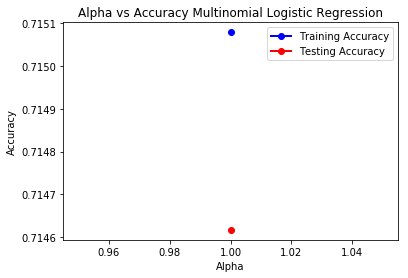

[0.7150782639134419]
[0.7146173113304088]


In [28]:
#c_arr = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0]
'''
c_arr = [1.0]
train_acc = []
test_acc = []
for c in c_arr:    
    classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=123, C=c)
    classifier.fit(X_train, Y_train)
    # Add to accuracy lists
    train_acc.append(accuracy_score(Y_train, classifier.predict(X_train)))
    test_acc.append(accuracy_score(Y_test, classifier.predict(X_test)))
'''
plt.figure(1)
plt.plot(c_arr, train_acc, color='blue', lw=2, marker='o', label="Training Accuracy")
plt.plot(c_arr, test_acc, color='red', lw=2, marker='o', label="Testing Accuracy")

plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Alpha vs Accuracy Multinomial Logistic Regression")
plt.legend(loc='upper right')
plt.show()

print(train_acc)
print(test_acc)